# RSCAM Week 2 exercises

## Lennard-Jones interatomic potential

In this lab we shall explore how we can use symplectic methods to simulate small clusters of atoms in a vacuum. Key to this is the Lennard-Jones (LJ) potential energy function ( https://en.wikipedia.org/wiki/Lennard-Jones_potential ), which we shall write as 

$$ U_{LJ}(r) = \frac{1}{r^{12}} - \frac{1}{r^6}$$

for interatomic distance $r>0$. This potential function can be parameterized in many different ways in order to more closely match real experiment, but we shall stick with the simple form above.

We can plot the LJ function below.

In [1]:
# If you're on the university machines then
# in order to play the animations we will need to update the
# matplotlib library. You only need to run this once.
# Running it more times will cause an error
#
# If you're running this on your laptop or another machine
# then you won't need to run this line.
# 

!pip install --user matplotlib --upgrade

Traceback (most recent call last):
  File "C:\Anaconda\Scripts\pip-script.py", line 3, in <module>
    import pip
  File "C:\Anaconda\lib\site-packages\pip\__init__.py", line 26, in <module>
    from pip.utils import get_installed_distributions, get_prog
  File "C:\Anaconda\lib\site-packages\pip\utils\__init__.py", line 27, in <module>
    from pip._vendor import pkg_resources
  File "C:\Anaconda\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3018, in <module>
    @_call_aside
  File "C:\Anaconda\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3004, in _call_aside
    f(*args, **kwargs)
  File "C:\Anaconda\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3046, in _initialize_master_working_set
    dist.activate(replace=False)
  File "C:\Anaconda\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2578, in activate
    declare_namespace(pkg)
  File "C:\Anaconda\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2152, in

In [2]:
# Import libraries
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
from IPython.display import HTML

In [3]:
# Define the function
def U_LJ(r): 
    
    # U_LJ(r) = r^-12 - r^-6
    
    potential = np.power(r,-12) - np.power(r,-6)
    
    return potential

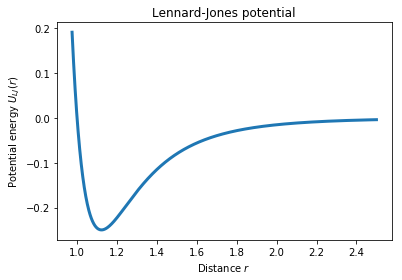

In [4]:
# Plot the curve
r_space = np.linspace(0.975,2.5,1000)

plt.plot( r_space, U_LJ(r_space),linewidth=3 )
plt.xlabel('Distance $r$')
plt.ylabel('Potential energy $U_{LJ}(r)$')
plt.title('Lennard-Jones potential')
plt.show()

We can see the potential has two main features:

1. A steep rise in energy (a _wall_) as $r$ gets small, preventing particles from getting too close.
2. An attractive part that pulls a particle inwards it, if it gets too far away. This attraction becomes less strong the further away it is.

**[1] Compute (by hand) the value of $r>0$ that minimizes the potential energy, and define that number as min_lj below**


In [5]:
# After differentiation and equating to zero
rmin = np.power(2,1/6)
print(rmin)

1.122462048309373


Just like in the spring example in Week 1, we think of the LJ potential as being an energy term between two atoms, where $r$ is the Euclidean distance between them. If we are in 2D with $q_i=[q_{i,x},q_{i,y}]\in\mathbb{R}^2$, then the energy term between particles 1 and 2 is $U_{LJ}(\|q_1-q_2\|)$, with

$$\|q_1-q_2\| = \sqrt{ (q_{1,x}-q_{2,x})^2 + (q_{1,y}-q_{2,y})^2 } $$ 

Thus the derivative of the potential energy with respect to, e.g. $q_{1,x}$ is (via chain rule)

$$ \frac{\partial}{\partial q_{1,x}} U_{LJ}(\|q_1-q_2\|) = U_{LJ}^\prime(\|q_1-q_2\|) \times \frac{\partial}{\partial q_{1,x}}\|q_1-q_2\|$$.

**[2] Complete the code below to define a function returning the energy and derivatives of the LJ function**

In [6]:
def derivatives_LJ(q1,q2):
    
    r = np.linalg.norm( q1-q2 )
    
    energy = U_LJ(r)
    
    # U(r) = r^-12 - r^-6
    #
    # U( f(q1,q2) ) = U'(r) * f_q1
    #
    
    q1x = q1[0] 
    q1y = q1[1]
    q2x = q2[0] 
    q2y = q2[1] 
    
    dU_dr = -12*np.power(r,-13) + 6*np.power(r,-7)    # Done
    
    dnorm_dq1x = (q1x-q2x)/r 
    dnorm_dq1y = (q1y-q2y)/r  # Done  
    dnorm_dq2x = -(q1x-q2x)/r  # Done 
    dnorm_dq2y = -(q1y-q2y)/r  # Done
    
    dulj_dq1x = dU_dr * dnorm_dq1x
    dulj_dq1y = dU_dr * dnorm_dq1y
    dulj_dq2x = dU_dr * dnorm_dq2x
    dulj_dq2y = dU_dr * dnorm_dq2y
    
    return energy, dulj_dq1x, dulj_dq1y, dulj_dq2x, dulj_dq2y
    

You can check your routine is correct below:

In [7]:
# To check your code is correct:
q1 = np.zeros(2)
q2 = np.array([ 1 , 1.5  ])
print( derivatives_LJ(q1,q2) )

# This should return 
# (-0.02828203892053, -0.050646360295, -0.0759695404434, 0.05064636029, 0.0759695404434)

(-0.028282038920537364, -0.0506463602956545, -0.07596954044348175, 0.0506463602956545, 0.07596954044348175)


Recall that Hamilton's equations are
$$\dot{q} = p$$
$$\dot{p} = -\nabla U(q)$$
with the $-\nabla U(q)$ known as the _force_. Now that we know the partial derivatives, we can define a function to give us the force (as a vector) and energy, using the derivatives we programmed in:

In [8]:
def force_LJ(q1,q2):
    
    F1 = np.zeros_like(q1) 
    F2 = np.zeros_like(q2)
    
    energy, du_dq1x, du_dq1y, du_dq2x, du_dq2y = derivatives_LJ(q1,q2)
    
    F1[0] = -du_dq1x
    F1[1] = -du_dq1y
    F2[0] = -du_dq2x
    F2[1] = -du_dq2y
    
    return energy, F1, F2 

How does this relate to clusters?

Let us consider the two dimensional _Lennard Jones Trimer_, which is three atoms bound together with a Lennard Jones potential. If the postion of the system is $q$, where $q = [q_{1,x},q_{1,y},q_{2,x},q_{2,y},q_{3,x},q_{3,y}]\in\mathbb{R}^6$ as usual, we define an LJ potential between each of them, so

$$ U(q) = U_{LJ}(\|q_1-q_2\|) + U_{LJ}(\|q_1-q_3\|) + U_{LJ}(\|q_2-q_3\|)$$

and as differentiation is linear, the forces are additive. So:

$$-\nabla U(q) = -\nabla U_{LJ}(\|q_1-q_2\|) - \nabla U_{LJ}(\|q_1-q_3\|) - \nabla U_{LJ}(\|q_2-q_3\|)$$

Thus the total force and energy comes from just adding together the terms we have just computed:

In [9]:
def total_force(q):
    
    # Get the coordinates
    q1 = q[0:2]
    q2 = q[2:4]
    q3 = q[4:6]
     
    # Find the derivatives for the three terms
    e12, f12, f21 = force_LJ(q1,q2)
    e13, f13, f31 = force_LJ(q1,q3)
    e23, f23, f32 = force_LJ(q2,q3)
    
    # Add 'em up
    pe = e12 + e13 + e23 
    f1 = f12 + f13 
    f2 = f21 + f23 
    f3 = f31 + f32 
    
    # the "hstack" function takes vectors and
    # stacks them on top of one another, so here
    # f is of length 6, like q and p.
    f = np.hstack([f1, f2, f3]) 
    
    # Return the values
    return pe, f 
    

Now we can define the position of our three particles and obtain the potential energy, and total force on the cluster. For example:

In [10]:
q1x = 0
q1y = 0
q2x = 1
q2y = 0.5 
q3x = 0.5 
q3y = 1
q = np.array([q1x, q1y, q2x, q2y, q3x, q3y])

print( total_force(q) )

(55.500287999999955, array([-8.84736000e-02, -8.84736000e-02,  7.20058982e+02, -7.19970509e+02,
       -7.19970509e+02,  7.20058982e+02]))


The `total_force` function returns the energy, then the vector of the force across all components.

**[3] Create a position vector `q0` that minimizes the total potential energy of the system and where the force is zero (up to machine precision).**

**   The total energy of this point should be -0.75 (up to machine precision).**

In [11]:
# [!] Edit the coordinates below:
q1x = 0
q1y = 0
q2x = rmin
q2y = 0
q3x = 0.5*rmin  
q3y = np.sqrt(rmin**2-(0.5*rmin)**2)
q0 = np.array([q1x,q1y,q2x,q2y,q3x,q3y])

print( total_force(q0) )
# This should print  (-0.75, array([0, 0, 0, 0, 0, 0]))
# Though due to machine limitations, the values may be e.g. 10^-16 instead of exactly 0.

(-0.7499999999999999, array([ 6.66133815e-16,  3.84592537e-16, -6.66133815e-16,  3.84592537e-16,
        0.00000000e+00, -7.69185075e-16]))


We can plot the points using matplotlib:

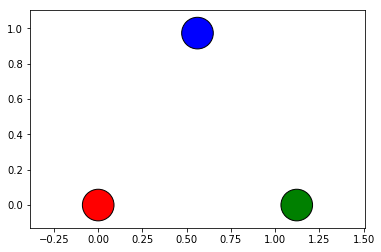

In [12]:
plt.scatter( q0[::2],q0[1::2],s=1000,c='rgb',edgecolor='k') 
plt.axis('equal')
plt.show()

We can simulate the dynamics using Euler's Method like in Week 1:


In [13]:
def Eulers_Method(q,p,h, force_function):
    
    # Compute the force
    pe_old, f = force_function(q)
    
    # Do the update
    qt = q + h * p 
    pt = p + h * f
    
    # Compute the new energies
    pe, f_new = force_function(qt)
    ke = np.sum( pt*pt) / 2 
    
    # Total energy is kinetic + potential
    total_e = ke + pe 
    
    # Return values 
    return qt, pt, total_e

We have a `run_simulation` function that does the loop through time, taking initial conditions as input, as well as the number of steps and timestep. It also takes the function used to take a step in time, and the function used to create the force.

In [14]:
def run_simulation(q0, p0, Nsteps, h, step_function, force_function):
    
    # Initialize the output trajectories
    q_traj = [] 
    p_traj = [] 
    e_traj = [] 
    t_traj = []

    # Set initial conditions
    q = np.copy(q0)
    p = np.copy(p0)
    t = 0

    # Main loop
    for n in range(Nsteps):
        
        # Step in time
        q,p,energy = step_function(q, p, h, force_function)
        t = t + h 

        # Save the system's data
        q_traj += [q] 
        p_traj += [p] 
        e_traj += [energy] 
        t_traj += [t] 

    # Format into numpy arrays
    q_traj = np.array(q_traj)
    p_traj = np.array(p_traj) 

    # Return the trajectories
    return q_traj, p_traj, e_traj, t_traj

Let's try running a simulation, with a timestep of `h=0.025` for a total time of `T=25`. We initialize our momentum to be a scaled normal random number.

In [36]:
# Initialize momentum in R^6
p0 = np.random.randn( 6 ) * 0.1 

And then run the simulation

In [37]:
h = 0.025
T = 25
Nsteps = int(T/h)

q_traj, p_traj, e_traj, t_traj = run_simulation(q0, p0, Nsteps, h, Eulers_Method, total_force)

Once the simulation has run we can output the energy:

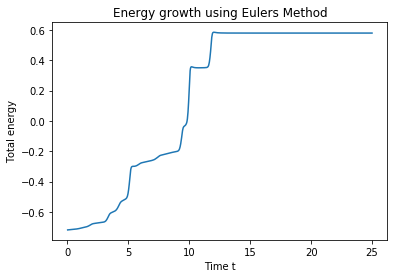

In [38]:
plt.plot( t_traj, e_traj )
plt.xlabel('Time t')
plt.ylabel('Total energy')
plt.title('Energy growth using Eulers Method')
plt.show()

As expected, the energy has grown over the course of the simulation. We can animate the trajectory in a rudimentary way using something like this:

In [39]:
def animate_trajectory(q_traj,skip=10,time_interval=50,colors='rgb'):
    # There are lots of ways to animate things in Python. This is 
    # a simple way of doing it.
    #
    # skip :: How many frames to skip
    # time_interval :: The time in ms between frames
    # colors :: A list of colours that we use for the particles
    
    frames = []   
    Nframes = int(len(q_traj)/skip) 
    
    for n in range(Nframes): 
        qq = q_traj[n*skip,:] 
        frame = plt.scatter( qq[::2],qq[1::2],s=250,edgecolor='k',c=colors)    

        frames.append( (frame,) )
    im_ani = animation.ArtistAnimation(plt.gcf(),frames,interval=time_interval);
    plt.close()
    return im_ani

In [40]:
# Create the animation
ani = animate_trajectory( q_traj)
# Display it in the notebook (as long as matplotlib is updated)
HTML(ani.to_jshtml())

The cluster gains energy until it breaks itself apart. We can reduce `h` to decrease the energy drift, but this will increase the number of required steps to reach `T` (and therefore increasing the time we have to wait for it to complete).

An alternative is to use _symplectic_ methods.

The symplectic Verlet or (Stormer) scheme is given as
$$ \left| \begin{array}{rcl} 
p(t+h/2)&\leftarrow&p(t) + (h/2)\, f( q(t) )\\
\qquad q(t+h)&\leftarrow&q(t) + h\, p(t+h/2)\\
p(t+h)&\leftarrow&p(t+h/2) + (h/2)\, f( q(t+h) )\\
\end{array}\right.$$


**[4] Code the Verlet method and run a simulation using the same `q0`,`p0`, `h` and `T` values as you used for Euler Method above. Make a plot of the resulting energy, and (if you wish) animate the trajectory of the cluster.**

In [42]:
def Verlet(q,p,h, force_function):
    
    # [!] Your code here
    pe, f = force_function(q)
    
    pt = p + (h/2)*f
    qt = q + h*pt
    
    pe, f = force_function(qt)
    pt = pt + (h/2)*f
    
    ke = np.sum( pt*pt) / 2
    
    total_e = pe + ke
    # Return values 
    return qt, pt, total_e
    
    

In [45]:
h = 0.025
T = 25
Nsteps = int(T/h)

q_traj, p_traj, e_traj, t_traj = run_simulation(q0, p0, Nsteps, h, Verlet, total_force)

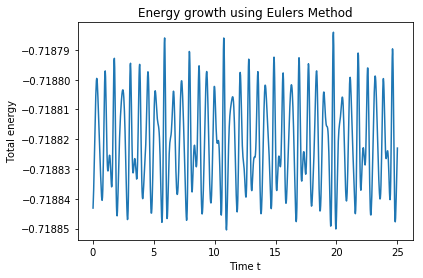

In [46]:
plt.plot( t_traj, e_traj )
plt.xlabel('Time t')
plt.ylabel('Total energy')
plt.title('Energy growth using Eulers Method')
plt.show()

In [47]:
# Create the animation
ani = animate_trajectory( q_traj)
# Display it in the notebook (as long as matplotlib is updated)
HTML(ani.to_jshtml())

You should see the cluster drift or rotate, but stay together as a whole. This is very different from the Euler scheme, even though the initial conditions are exactly the same! (**Optional: Change `p0` to remove linear drift and rotation from the system**).

This is closer to the true dynamics, because the total energy does not drift like in the Euler method.

***

## The basin-hopping problem

Consider a particular initial condition for the LJ trimer:

$$q_1 = \left[\begin{array}{c} a\\-b/3 \end{array}\right], \quad q_2 = \left[\begin{array}{c} -a\\-b/3 \end{array}\right], \quad q_3 = \left[\begin{array}{c} 0\\+2b/3 \end{array}\right],$$

for choices of $a$ and $b$. This gives us three particles positioned in an isosceles triangle, and because of the choice of potential the particles should stay in an isosceles formation (**optional: check this!**).

**[5] Create a function `create_q0` which takes $a$ and $b$ as input, and outputs the full initial condition $q(a,b)=[q_1(a,b),q_2(a,b),q_3(a,b)]\in\mathbb{R}^6$.**

In [ ]:
def create_q0(a,b):
    
    # [!] Your code here
    
    return q0

# As a test
# create_q0(.8,1.1) should output
#
# array([ 0.8   , -0.36666667, -0.8 , -0.36666667,  0.  ,0.73333333])


We can run simulations of the trimer using the initial condition generated from the choice of an $a$ and $b$.

**[6] Find an **$a$** and **$b$** value with **$ 0.5\leq a\leq 0.8 $** and **$ 0.5\leq b\leq 1.5 $** such that **$q_{1,y}$** flips sign more than three times, when simulated using `h=0.025` and `T=50` with zero initial momentum in the Verlet method. (You may wish to animate this to see what's happening.)**

** You should be able to do find this using trial and error, but you may of course automate the search if you wish. As a starting point, you should see that for **$(a,b)=(0.75,1)$** there are only two sign flips.**

To try to understand this system we can look at the energy landscape of positions as we change $a$ and $b$.

**[7] Make a plot of the potential energy **$U(q(a,b))$** on the domain **$a\in[0.4,1.5],\,\,b\in[-2,2]$**.**

**There are many ways to do this. One way is to build an **$N\times N$** matrix **$Z$**, with **$Z_{ij} = U(q(A_i,B_j))$** where **$A$** and **$B$** are vectors spanning the domains. You can use the `pcolor` or `imshow` routines to plot the values in this matrix. Alternatively you may wish to plot this in 3D.**

If you change the plot so that you focus on values for $U(q)\in[-0.75,0]$ you should see a crescent-shape with two distinct stationary points.

**[8] On your plot, plot a contour line at the value of initial potential energy you found in Q6. Additionally plot the trajectory for Q6 on this plot (in a and b coordinates, so **$a=q_{1,x},\, b=-3q_{1,y}$**). You should see it fills in the curve.**

As the kinetic energy is initially zero, the maximum potential energy available to the system is set by the initial condition. Thus the system can explore the parts of the system inside the contour, but the space outside the contour is too high energy for the system to access.

As you change the initial energy levels of the system we can see that some parts of the space become inaccessable as a large amount of energy is required to pass between them. This is exactly what we can see in physics where we are in one stable configuration, but require an additional _activation energy_ to overcome an energy barrier and move to a new configuration.

###### Optional

- Its worth noting that you can save your movies as gifs or mp4s using the asociated save functions.

- Combine Q6 and Q7 to make a plot showing the number of sign flips you observe as you vary the initial conditions $a$ and $b$ on some domain.

-  A common test system used for many numerical algorithms is the Lennard-Jones 7 cluster. Adapt the code above to include seven particles, instead of just three. The potential energy function for a Lennard Jones cluster of size $N$ is just
$$ U(q) = \sum_{i=1}^N \sum_{i>j}^N U_{LJ}(\|q_i-q_j\|) $$
There are four distinct minimum configurations for this system. The particles should re-arrange themselves into these minima if you initialize them with enough energy.

- A simple model for water is to use the LJ trimer with a spring potential (exactly as we did in week 1) connecting particle 1 to 2, and particle 2 to 3, with rest length set to $\sqrt[6]{2}$. In addition, a potential is added that keeps the angle $\theta$ close to some value. We can use something like 
$$ V_{angle}(\theta) = (\theta-\pi/2)^2$$
to keep the angle close to $\pi/2$. We can get the angle $\theta$ between particles 1-2 and 2-3 by using 
$$\theta = \text{arccos}( (q_1-q_2)\cdot(q_2-q_3)/\|q_1-q_2\|\|q_2-q_3\| )$$
and then we can get the forces by using chain rule. 
Simulate a water molecule by adding spring potentials and this angle potential. 

- Its worth noting that though the Verlet scheme does give roughly constant energy preservation, it does give some wiggles in the energy. Find an initial energy choice such that there should be no sign flips in the trimer (check your result for Q8), but when simulating with a sufficiently large $h$ the random energy spikes in Verlet allow a barrier crossing without the cluster breaking apart.

